In [1]:
import xarray as xr
import matplotlib.dates as mdates
import numpy as np
import matplotlib
from matplotlib import rcParams
import datetime
import pandas as pd
import cftime
import pylab as plt
import netCDF4 as nc
from numpy import ma
import dask as dd

from matplotlib.colors import LinearSegmentedColormap,ListedColormap
from matplotlib import cm
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point

In [2]:
#stash codes
stash_ch4 = 'mass_fraction_of_methane_in_air'
stash_co = 'mass_fraction_of_carbon_monoxide_in_air'
stash_ch4_oh = 'm01s50i041'
stash_oh = 'mass_fraction_of_hydroxyl_radical_in_air'
stash_o3 = 'mass_fraction_of_ozone_in_air'
stash_trop = 'm01s50i062'
stash_mass = 'm01s50i063'
stash_temp = 'surface_temperature'

In [3]:
#define variables
ch4_mr = 16
n_a = 6.022e23
per_sec_to_per_yr = 60*60*24*360
g_to_Tg = 1e12

In [48]:
#define functions
def molec_cm3(conc_kg_kg, mass, vol, mr):
    molec_box = conc_kg_kg*mass/mr*1000*n_a #molecules per box
    cm3 = molec_box/(vol*1e6) #molec per cm3
    return cm3

def Tg_yr_m3(conc_grd_s,vol,mr):
    flux_box = (conc_grd_s*mr*per_sec_to_per_yr)/g_to_Tg #Tg per year per box
    flux_m3 = flux_box/vol #Tg per year per m3
    return flux_m3

def Tg_yr_box(conc_grd_s,mr):
    flux_box = (conc_grd_s*mr*per_sec_to_per_yr)/g_to_Tg #Tg per year per box
    return flux_box

# Convert methane input to ppb units
def ppb(conc_kg_kg,mr):
    g_bil = np.multiply(conc_kg_kg,28.97*1e9)
    parts_per_bil = np.divide(g_bil,mr) 
    return parts_per_bil

In [5]:
# Obtain area and volume, and airmass data required
data_alt = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/vol_n96.nc')
vol = data_alt.grid_cell_volume
vol = vol.data

airmass_data_949=xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_airmass_PI.nc',chunks={'time':12})
airmass_949=airmass_data_949.variables[stash_mass][:]
airmass_data_443 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_airmass_atm.nc',chunks={'time':24})
airmass_443=airmass_data_443.airmass_atm[:]

area = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/areacella_fx_UKESM1-0-LL_piControl_r1i1p1f2_gn.nc')
box_area = area.areacella

total_area = np.sum(box_area)
area_scaled = box_area/total_area
lat_area_scaled = area_scaled[:,0]#1D array of latitude scaling values

In [6]:
# Import required data
ch4_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_ch4_PI.nc',chunks={'time':24})
ch4_949 = ch4_data_949.variables[stash_ch4][:]
time_949 = ch4_data_949.time

ch4_data_443 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_ch4.nc',chunks={'time':24})
ch4_443 = ch4_data_443.ch4[:]
time_443 = ch4_data_443.time

trop_data_949=xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_trop_mask_PI.nc',chunks={'time':24})
trop_data_443=xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_trop_mask.nc',chunks={'time':24})
#trop_949 = trop_mask_data_949.variables[stash_trop]

In [7]:
# Convert and set up means
ch4_conc_949 = ppb(ch4_949,ch4_mr)
ch4_conc_443 = ppb(ch4_443,ch4_mr)

trop_data_949['mask'] = xr.ones_like(trop_data_949.variables[stash_trop])
trop_data_949['mask'] = trop_data_949.mask.where(trop_data_949.variables[stash_trop]==1,other=0.)
trop_data_443['mask'] = xr.ones_like(trop_data_443.trop_mask)
trop_data_443['mask'] = trop_data_443.mask.where(trop_data_443.trop_mask>=0.9999999,other=0.)

# ch4_trop_949 = ch4_conc_949*trop_data_949.mask
# trop_data_443['mask'] = trop_data_443.trop_mask.where(trop_data_443.trop_mask>0.99999,other=0.)

map_mean_949 = dd.array.average(ch4_conc_949,weights=trop_data_949.mask,axis=(0,1))
map_mean_443 = dd.array.average(ch4_conc_443,weights=trop_data_443.mask,axis=(0,1))
surface_mean_949 = dd.array.average(ch4_conc_949[:,0,:,:],axis=0)
surface_mean_949 = dd.array.average(ch4_conc_949[:,0,:,:],axis=0)

gm_949 = dd.array.average(ch4_conc_949,weights=trop_data_949.mask,axis=(1,2,3))
gm_443 = dd.array.average(ch4_conc_443,weights=trop_data_443.mask,axis=(1,2,3))

In [8]:
# Final plotting variables
lon = ch4_data_949.longitude
lat = ch4_data_949.latitude
map_plot_949 = map_mean_949.compute()
map_plot_443 = map_mean_443.compute()
gm_plot_443 = gm_443.compute()
gm_plot_949 = gm_949.compute()

In [9]:
map_diff = map_plot_949-map_plot_443

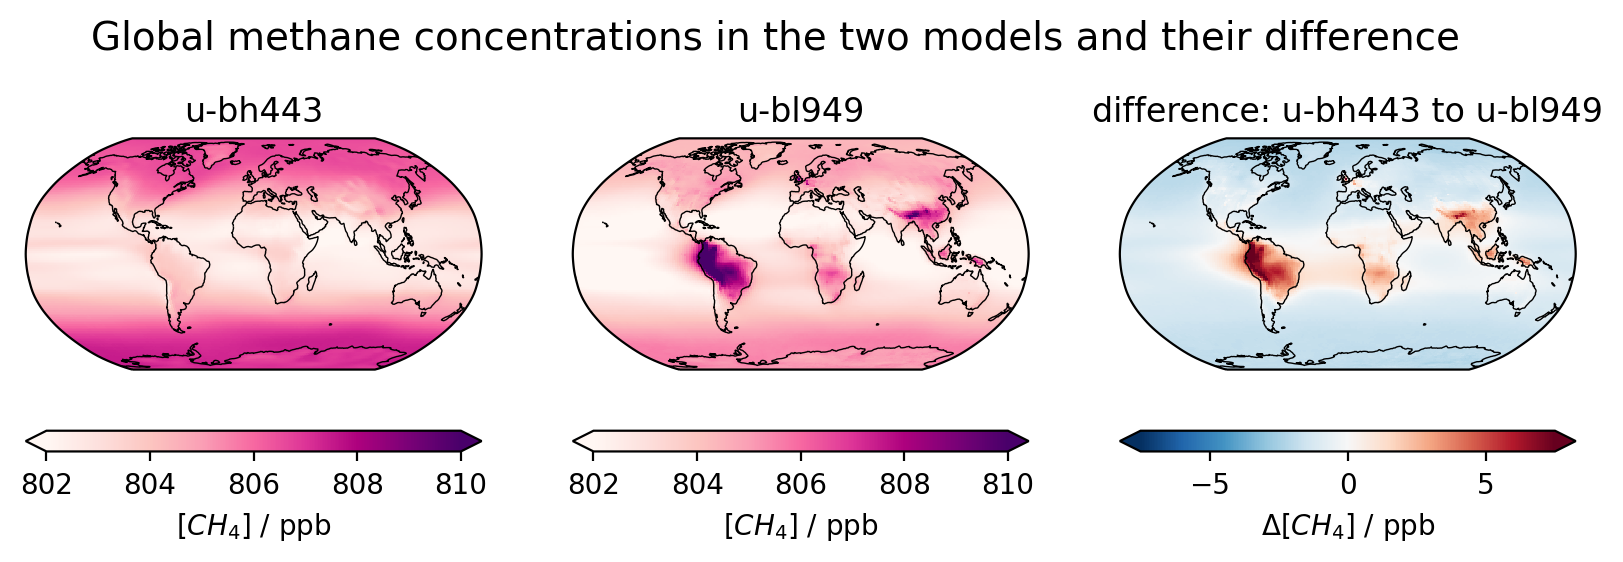

In [73]:
# Global difference in methane between two models

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3, figsize=(10,2.7), subplot_kw={"projection": ccrs.Robinson()},dpi=200)
fig.suptitle('Global methane concentrations in the two models and their difference',fontsize=14,y=1)

ax1.set_title('u-bh443')
ax1.coastlines(linewidth=0.5)
bh_cyclic, lon_plot = add_cyclic_point(map_plot_443, coord=lon)   
c1 = ax1.pcolormesh(lon_plot,lat,bh_cyclic, cmap='RdPu',transform=ccrs.PlateCarree(central_longitude=0),vmin=802,vmax=810)
cb1 = fig.colorbar(c1, label= '$[CH_4]$ / ppb', orientation="horizontal",extend='both',ax=ax1)

ax2.set_title('u-bl949')
ax2.coastlines(linewidth=0.5)
bl_cyclic, lon_plot = add_cyclic_point(map_plot_949, coord=lon)   
c2 = ax2.pcolormesh(lon_plot,lat,bl_cyclic, cmap='RdPu',transform=ccrs.PlateCarree(central_longitude=0),vmin=802,vmax=810)
cb2 = fig.colorbar(c2, label= '$[CH_4]$ / ppb', orientation="horizontal",extend='both',ax=ax2)

ax3.set_title('difference: u-bh443 to u-bl949')
ax3.coastlines(linewidth=0.5)
diff_cyclic, lon_plot = add_cyclic_point(map_diff, coord=lon)
c3 = ax3.pcolormesh(lon_plot,lat,diff_cyclic, cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0),vmin=-7.5,vmax=7.5)
cb2 = fig.colorbar(c3, label= '\u0394$[CH_4]$ / ppb', orientation="horizontal",extend='both',ax=ax3)

# plt.savefig('Figures/ComparedMaps.png',dpi=300)

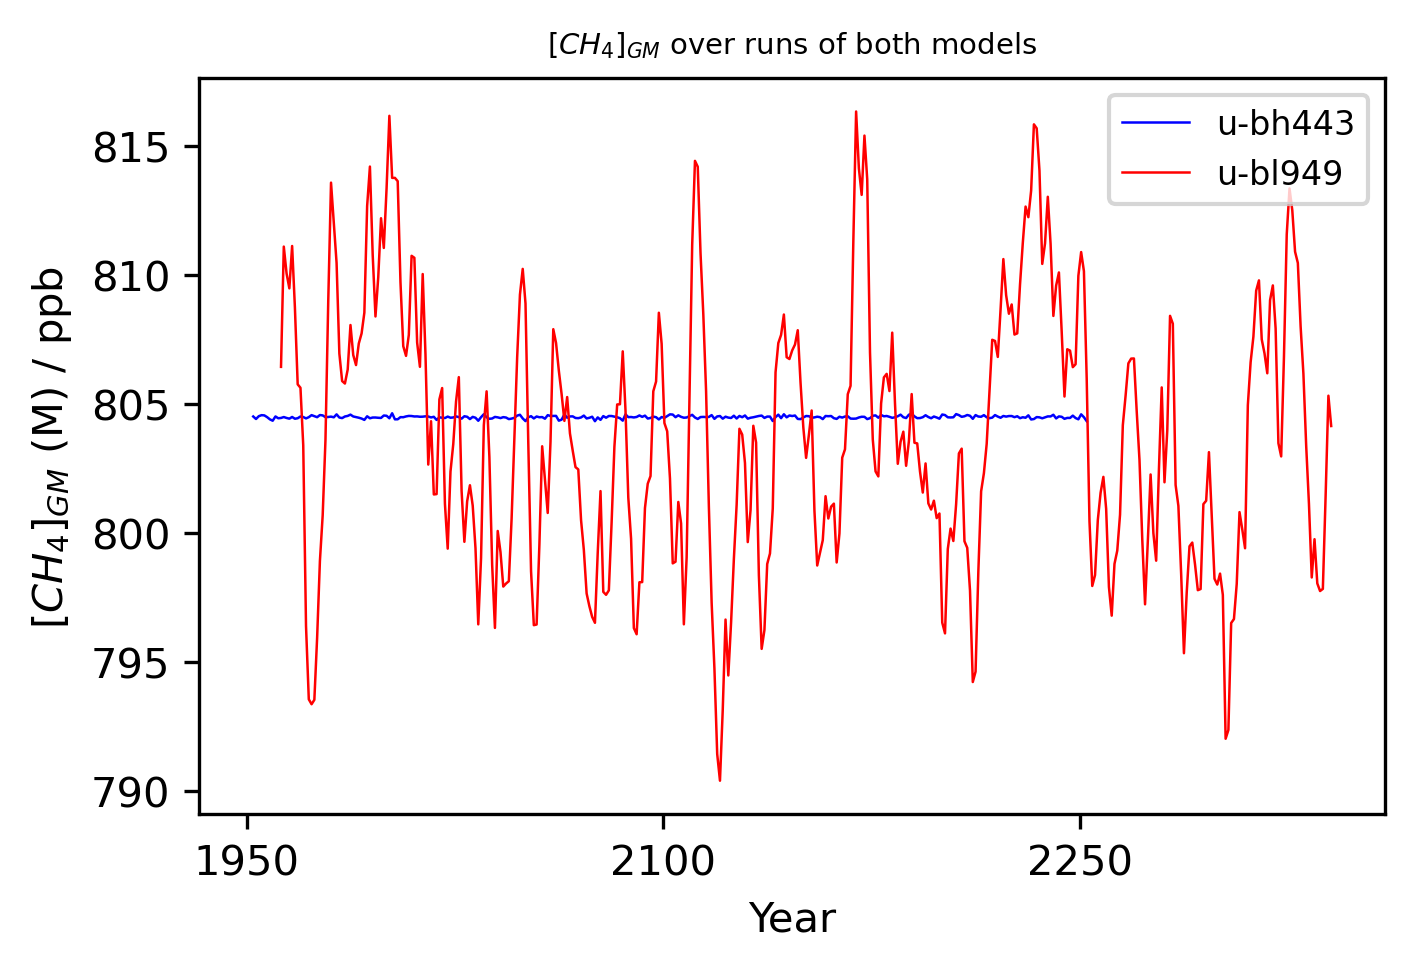

In [74]:
# Plot CH4 GM on same plot

fig = plt.figure(figsize=(5.1,3.25), dpi=300)
ax = plt.axes()

ax.set_xlabel('Year')
ax.set_ylabel('$[CH_4]_{GM}$ (M) / ppb')
plt.title('$[CH_4]_{GM}$ over runs of both models', fontsize = 7)

ax.plot(time_443, gm_plot_443, c='blue', linewidth=0.6,label='u-bh443')
ax.plot(time_949, gm_plot_949, c='red', linewidth=0.6,label='u-bl949')
plt.legend(fontsize = 8)
# plt.savefig('Figures/ch4_gm_on_same_plot.png', dpi=300)

In [12]:
# Calculate gm_diff stats
gm_diff = gm_plot_949[0:301] - gm_plot_443
plots = (gm_plot_443,gm_plot_949,gm_diff)

for model in plots:
    sig = np.std(model)
    mn = np.mean(model)
    percdev = (sig/mn)*100
    print(sig,mn,percdev)

0.054677214 804.4838 0.006796558591304347
5.1578436 803.72296 0.641743978485465
5.229355 -0.48088607 -1087.4415397644043


In [13]:
# # Map plot of Methane in ubl-949

# fig = plt.figure(figsize=(3.5,2.625), dpi=300)

# ax = plt.axes(projection=ccrs.Robinson(central_longitude=0, globe=None))
# ax.set_global()
# ax.coastlines(linewidth=0.5)

# ch4_cyclic, lon_plot = add_cyclic_point(map_plot_949, coord=lon)   


# plt.pcolormesh(lon_plot,lat,ch4_cyclic, cmap='RdPu',transform=ccrs.PlateCarree(central_longitude=0),vmin=1e13,vmax=2e13)

# plt.title('Global tropospheric methane concentrations')
# plt.colorbar(label = '$[CH_4]$ / molec. $cm^{-3}$' ,orientation='horizontal',pad=0.05, extend='both')

In [14]:
# # Map plot of Methane in ubl-949

# fig = plt.figure(figsize=(3.5,2.625), dpi=300)

# ax = plt.axes(projection=ccrs.Robinson(central_longitude=0, globe=None))
# ax.set_global()
# ax.coastlines(linewidth=0.5)

# ch4_cyclic, lon_plot = add_cyclic_point(surface_mean_949, coord=lon)   


# plt.pcolormesh(lon_plot,lat,ch4_cyclic, cmap='RdPu',transform=ccrs.PlateCarree(central_longitude=0))

# plt.title('Global surface methane concentrations')
# plt.colorbar(label = '$[CH_4]$ / molec. $cm^{-3}$' ,orientation='horizontal',pad=0.05, extend='both')

In [46]:
# CH4 OH Flux data
flux_data_949 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bl949/ubl949_ch4_oh_flux_PI.nc',chunks={'time':12})
flux_grid_949 = flux_data_949[stash_ch4_oh][:]

flux_data_443 = xr.open_dataset(f'/gws/nopw/j04/gcp_ch4/u-bh443/u-bh443_301yrs_CH4_OH_tendency.nc',chunks={'time':12})
flux_grid_443 = flux_data_443.ch4_oh_rxn_flux[:]

time_oh_949 = flux_data_949.time

In [62]:
# Convert reaction flux to Tg per grid box
flux_949 = Tg_yr_box(flux_grid_949,ch4_mr)
flux_443 = Tg_yr_box(flux_grid_443,ch4_mr)

In [63]:
# Set up plots, need to make a second code to plot if want both trop and surface at the same time
trop_map_flux_949 = flux_949.where(trop_data_949.mask==1,other=0.)
trop_map_flux_443 = flux_443.where(trop_data_443.mask==1,other=0.)

In [65]:
# Calculate the total column flux, averaging over time and summing over altitudes
trop_tot_flux_949 = np.sum(np.mean(trop_map_flux_949,axis=0),axis=0)
trop_tot_flux_443 = np.sum(np.mean(trop_map_flux_443,axis=0),axis=0)

# gm_lon_mean_949 = dd.array.average(flux_949,weights=trop_data_949.mask,axis=(1,2,3))
# gm_lon_mean_443 = dd.array.average(flux_443,weights=trop_data_443.mask,axis=(1,2,3))

lon=flux_data_949.longitude
lat=flux_data_949.latitude

In [66]:
plot_map_flux_949 = trop_tot_flux_949.compute()
plot_map_flux_443 = trop_tot_flux_443.compute()
flux_diff = plot_map_flux_949 - plot_map_flux_443

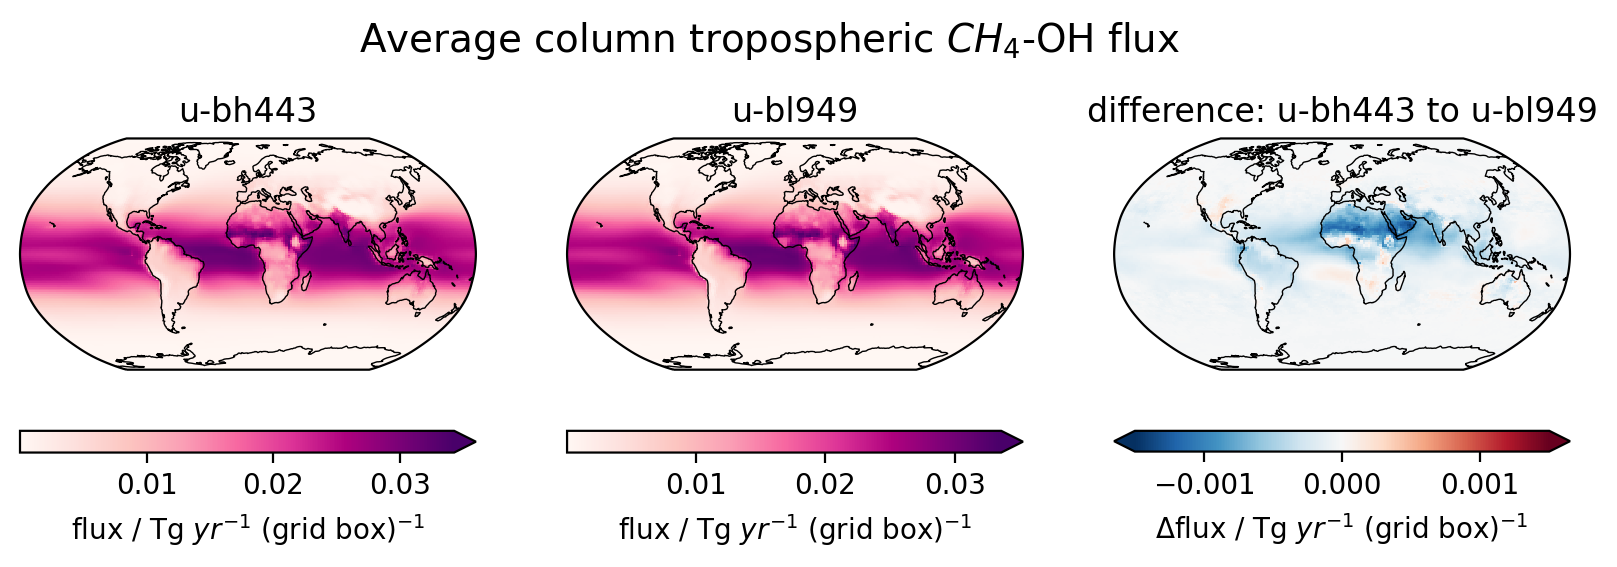

In [72]:
# Global difference in methane between two models

fig, (ax1,ax2,ax3) = plt.subplots(nrows=1,ncols=3, figsize=(10,2.7), subplot_kw={"projection": ccrs.Robinson()},dpi=200)
fig.suptitle('Average column tropospheric $CH_4$-OH flux',fontsize=14,y=1)

ax1.set_title('u-bh443')
ax1.coastlines(linewidth=0.5)
bh_cyclic, lon_plot = add_cyclic_point(plot_map_flux_443, coord=lon)   
c1 = ax1.pcolormesh(lon_plot,lat,bh_cyclic, cmap='RdPu',transform=ccrs.PlateCarree(central_longitude=0))#,vmin=0,vmax=2e-16)
cb1 = fig.colorbar(c1, label= 'flux / Tg $yr^{-1}$ (grid box$)^{-1}$', orientation="horizontal",extend='max',ax=ax1)

ax2.set_title('u-bl949')
ax2.coastlines(linewidth=0.5)
bl_cyclic, lon_plot = add_cyclic_point(plot_map_flux_949, coord=lon)   
c2 = ax2.pcolormesh(lon_plot,lat,bl_cyclic, cmap='RdPu',transform=ccrs.PlateCarree(central_longitude=0))#,vmin=0,vmax=2e-16)
cb2 = fig.colorbar(c2, label= 'flux / Tg $yr^{-1}$ (grid box$)^{-1}$', orientation="horizontal",extend='max',ax=ax2)

ax3.set_title('difference: u-bh443 to u-bl949')
ax3.coastlines(linewidth=0.5)
diff_cyclic, lon_plot = add_cyclic_point(flux_diff, coord=lon)
c3 = ax3.pcolormesh(lon_plot,lat,diff_cyclic, cmap='RdBu_r',transform=ccrs.PlateCarree(central_longitude=0),vmin=-15e-4,vmax=15e-4)
cb2 = fig.colorbar(c3, label= '\u0394flux / Tg $yr^{-1}$ (grid box$)^{-1}$', orientation="horizontal",extend='both',ax=ax3)

# plt.savefig('Figures/TropFlux.png',dpi=300)

In [58]:
# Calculate total OH/Methane reaction per year

flux_per_yr_949 = Tg_yr_box(flux_grid_949,ch4_mr)
trop_flux_yr_949 = flux_per_yr_949.where(trop_data_949.mask==1,other=0.)
global_flux_949 = np.sum(trop_flux_yr_949,axis=(1,2,3))

flux_per_year_443 = Tg_yr_box(flux_grid_443,ch4_mr)
trop_flux_yr_443 = flux_per_year_443.where(trop_data_443.mask==1,other=0.)
global_flux_443 = np.sum(trop_flux_yr_443,axis=(1,2,3))

In [59]:
plot_flux_949 = global_flux_949.compute()
plot_flux_443 = global_flux_443.compute()

In [60]:
# Calculate gm_diff stats
gm_diff = plot_flux_443[10:] - plot_flux_949[:291]
gm_diff.name = 'flux_diff'
plot_flux_949.name  ='flux_949'
plot_flux_443.name = 'flux_443'
plots = (plot_flux_443,plot_flux_949,gm_diff)

print('          mean             std                 %dev')

for model in plots:
    sig = np.std(model.data)
    mn = np.mean(model.data)
    percdev = (sig/mn)*100
    print(model.name,mn,sig,percdev)

          mean             std                 %dev
flux_443 226.3700442697207 2.2724758073080666 1.003876557359508
flux_949 223.99980424395713 2.1495486833489026 0.9596207865466879
flux_diff 2.249511997882266 3.0423939341187958 135.246841847608


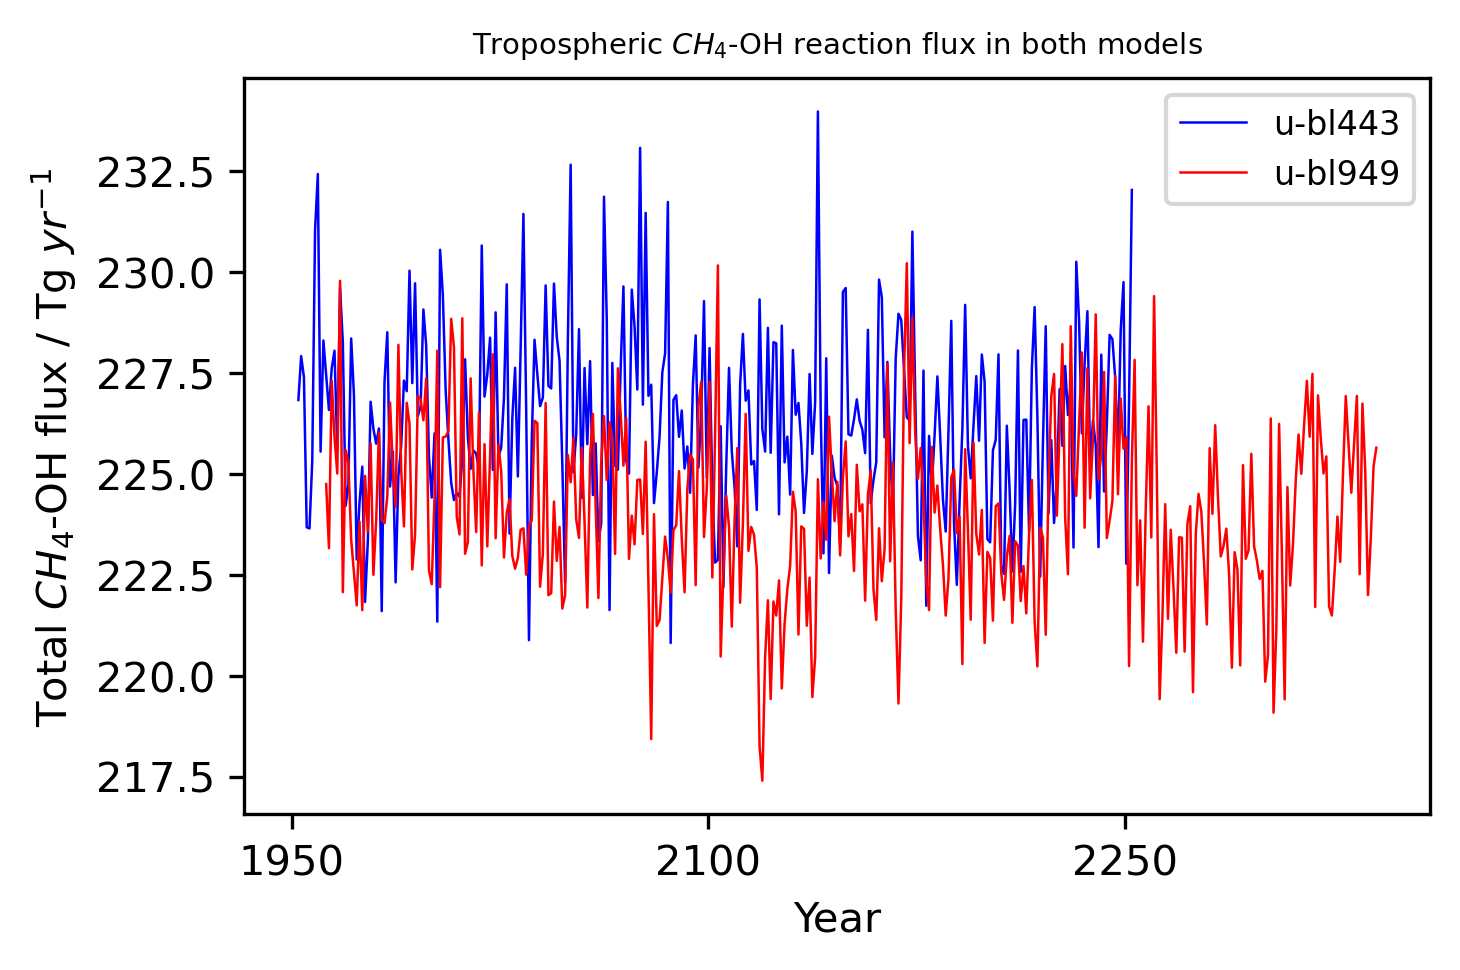

In [61]:
# Plot global total flux over time

fig = plt.figure(figsize=(5.1,3.25), dpi=300)
ax = plt.axes()

ax.set_xlabel('Year')
ax.set_ylabel('Total $CH_4$-OH flux / Tg $yr^{-1}$')
plt.title('Tropospheric $CH_4$-OH reaction flux in both models', fontsize = 7)

ax.plot(time_443, plot_flux_443, c='blue', linewidth=0.6,label='u-bl443')
ax.plot(time_949, plot_flux_949, c='red', linewidth=0.6,label='u-bl949')
plt.legend(fontsize = 8)
# plt.savefig('Figures/ch4_gm_on_same_plot.png', dpi=300)

In [24]:
# # Map plot of Methane-OH flux in ubl-949

# fig = plt.figure(figsize=(3.5,2.625), dpi=300)

# ax = plt.axes(projection=ccrs.Robinson(central_longitude=0, globe=None))
# ax.set_global()
# ax.coastlines(linewidth=0.5)

# ch4_flux_cyclic, lon_plot = add_cyclic_point(map_mean_flux_949, coord=lon)   


# plt.pcolormesh(lon_plot,lat,ch4_flux_cyclic, cmap='RdPu',transform=ccrs.PlateCarree(central_longitude=0))

# plt.colorbar(label = 'Methane - OH flux' ,orientation='horizontal',pad=0.05, extend='both')